### COMP 473 Group Project

#### Facial Expression Recognition: 6-Class Classification

##### Importing main libraries used

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import random
import PIL
import pandas as pd

classes = ['anger', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

#### Training Metrics Graph
Automatically update loss and accuracy of training and validation set and display the graph as the model gets trained

In [2]:
from IPython.display import clear_output


class PlotTrain(tf.keras.callbacks.Callback):

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]

        #To plot the graph
        metrics = [x for x in logs if 'val' not in x]

        f, axs = plt.subplots(1, len(metrics), figsize=(15, 5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), self.metrics[metric], label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), self.metrics['val_' + metric], label='val_' + metric)

        axs[i].legend()
        axs[i].grid()
        plt.tight_layout()
        plt.show()

In [3]:
def myClassType(myClass):
    return_class = []
    for i in myClass:
        if (i == 0):
            return_class += ['anger']
        if (i == 1):
            return_class += ['disgust']
        if (i == 2):
            return_class += ['fear']
        if (i == 3):
            return_class += ['happy']
        if (i == 4):
            return_class += ['sadness']
        if (i == 5):
            return_class += ['surprise']
    return return_class

### Sample image from each class

S076_005_00000012-8.7.png
S058_005_00000009-6.9.png
S050_006_00000021-1.2.png
S095_010_00000010-1.8.png
S102_003_00000012-9.9.png
S132_008_00000007-3.3.png


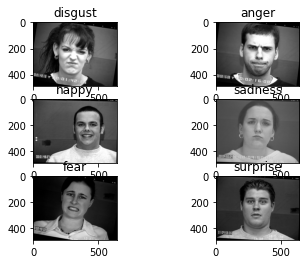

In [4]:
path = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+_Complete'

for index, directory_name in enumerate(os.listdir(path)):
    joined_directory = os.path.join(path, directory_name)
    sample_image = random.choice(os.listdir(joined_directory))
    print(sample_image)
    image = PIL.Image.open(os.path.join(joined_directory, sample_image)).convert('I')
    plt.subplot(3, 2, index + 1)
    plt.title(directory_name)
    plt.imshow(image)

### Printing of dataframe to show matching labels

In [5]:

#load all the data
def get_all_file_paths(path):
    all_filenames = []
    for root, subdirs, files in os.walk(path):
        for name in files:
            absolute_filepath = os.path.join(root, name)
            relative_file_path = os.path.join(os.path.basename(root), name)
            all_filenames.append(relative_file_path)
            # print(name)
    return all_filenames


def get_label(file_name):
    if 'angry' in str(file_name):
        return 0
    if 'disgust' in str(file_name):
        return 1
    if 'fear' in str(file_name):
        return 2
    if 'happy' in str(file_name):
        return 3
    if 'sad' in str(file_name):
        return 4
    if 'surprise' in str(file_name):
        return 5


categories = []

filenames = get_all_file_paths(path)
# use list() to show all the values inside a list
# print(list(filenames))
# randomize the files
random.shuffle(filenames)
for filename in filenames:
    categories.append(get_label(filename))
# print(list(categories))

# join the filename and categories list together

dataframe = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


<AxesSubplot: >

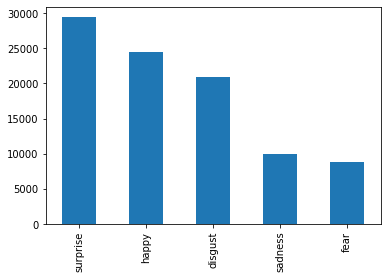

In [6]:
dataframe["category"] = dataframe["category"].replace(
    {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sadness', 5: 'surprise', })
dataframe['category'].value_counts().plot.bar()

### Training and Testing Models

Code implementation for each modes is the same throughout the experiment.
<br>Thus, only the first model contains information and comments about the implmentation.
<br>Simply need to change the variables 'path', 'MODEL_NAME' for each models
<br>
<br>To avoid overfitting, early stopping feature is implemented to stop the training (TO DO)

## ====No Pre-Processing=====

Training and Testing on the basic model with Dataset1

In [33]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CK_s1'
dataset_2_folder_name = 'CK_s2'
dataset_3_folder_name = 'CK_s3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

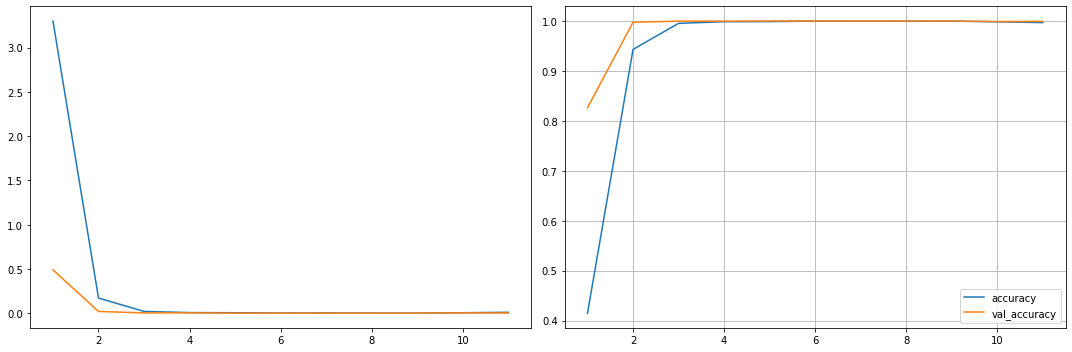

142/142 [==============================] - 42s 282ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0027 - val_accuracy: 0.9993


In [8]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='valid', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    # tf.keras.layers.Resizing(28, 28),

    #After Conv2D image shape = (28, 28, 3)
    # pooling layer to change image shape = (14, 14, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    #kernel size change to 7x7
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),

    #After Conv2D image shape = (8, 8, 3)
    # pooling layer to change image shape = (4, 4, 3)
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Flatten-Dense
    tf.keras.layers.Flatten(),

    ## 1st layer
    # number inside Dense is the number of nodes. usually use 2^n
    tf.keras.layers.Dense(256, activation="relu"),

    # helps prevent overfittng
    tf.keras.layers.Dropout(0.2),

    ## second layer. we must have 6 final nodes because we have 6 classes.
    # softmax: compress resulting number between 0~1, used in category problems.
    # If you add up the probability of each class we get 1.
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
# prints summary of our model.
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

# monitor	Quantity to be monitored.
# patience	Number of epochs with no improvement after which training will be stopped.
# verbose	Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action.
# mode	One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 100s 2s/step
              precision    recall  f1-score   support

       anger       0.23      0.15      0.18      3195
     disgust       0.22      0.26      0.24      4260
        fear       0.00      0.00      0.00      1775
       happy       0.80      0.63      0.70      4970
     sadness       0.06      0.10      0.07      1420
    surprise       0.67      0.69      0.68      5680

    accuracy                           0.41     21300
   macro avg       0.33      0.30      0.31     21300
weighted avg       0.45      0.41      0.42     21300



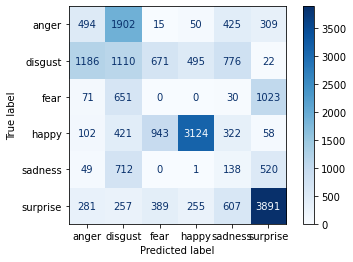

In [9]:
# WEIGHT_NAME = "1_basic_d1.h5"

test_dir = os.path.join(project_folder_name, folder_type[1])
# test_dir = '/home/ryan/Documents/GitHub/COMP_473_Project/CK+'
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset2

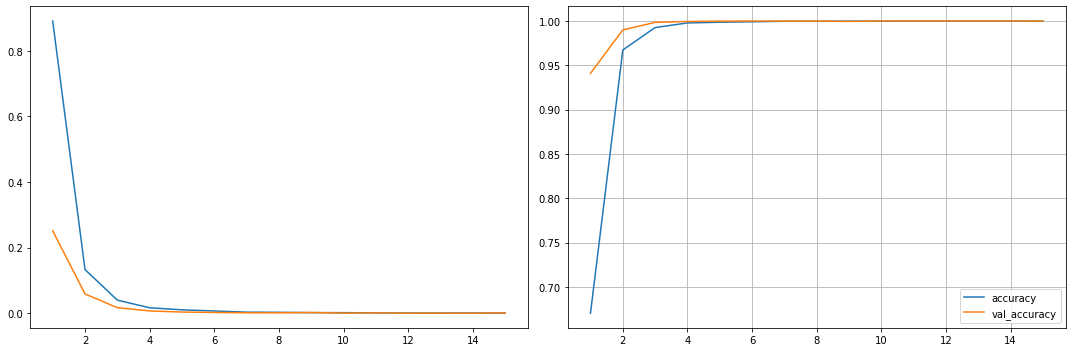

141/141 [==============================] - 42s 287ms/step - loss: 6.7758e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accuracy: 0.9999


In [10]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])
NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 94s 2s/step
              precision    recall  f1-score   support

       anger       0.23      0.75      0.35      3195
     disgust       0.51      0.27      0.36      4260
        fear       0.06      0.02      0.03      1775
       happy       0.75      0.42      0.54      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.53      0.52      0.53      5680

    accuracy                           0.40     21655
   macro avg       0.35      0.33      0.30     21655
weighted avg       0.45      0.40      0.39     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


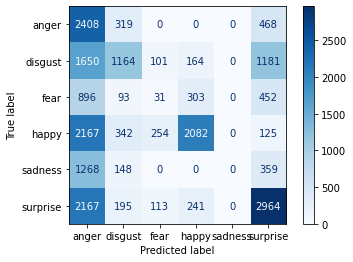

In [11]:
# WEIGHT_NAME = '1_basic_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

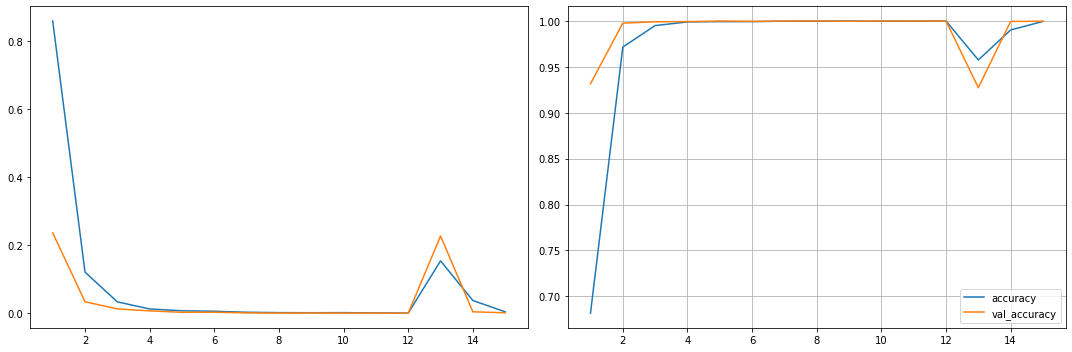

141/141 [==============================] - 45s 304ms/step - loss: 0.0042 - accuracy: 0.9996 - val_loss: 0.0015 - val_accuracy: 0.9998


In [12]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_basic_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 100s 2s/step
              precision    recall  f1-score   support

       anger       0.41      0.29      0.34      3195
     disgust       0.43      0.50      0.46      4260
        fear       0.02      0.00      0.00      1775
       happy       0.83      0.78      0.80      4970
     sadness       0.42      0.40      0.41      1775
    surprise       0.59      0.81      0.68      5680

    accuracy                           0.57     21655
   macro avg       0.45      0.46      0.45     21655
weighted avg       0.53      0.57      0.54     21655



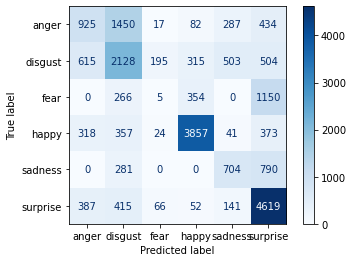

In [13]:
# WEIGHT_NAME = '1_basic_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


### ====Image Cropping====

Training and Testing on the image cropping model with Dataset1

In [14]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Cropping_1'
dataset_2_folder_name = 'CKD_Cropping_2'
dataset_3_folder_name = 'CKD_Cropping_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

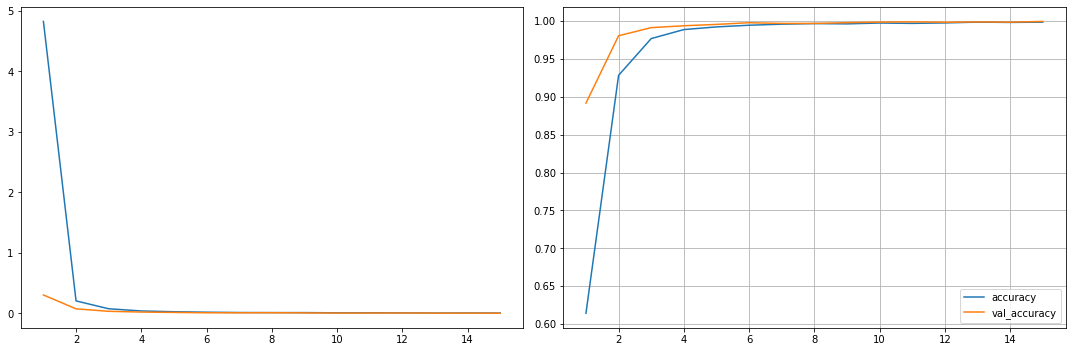

142/142 [==============================] - 15s 104ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0017 - val_accuracy: 0.9996


In [15]:


path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 153s 4s/step
              precision    recall  f1-score   support

       anger       0.34      0.06      0.11      3195
     disgust       0.29      0.11      0.16      4260
        fear       0.11      0.07      0.09      1775
       happy       0.08      0.04      0.05      4970
     sadness       0.00      0.00      0.00      1420
    surprise       0.33      0.88      0.48      5680

    accuracy                           0.28     21300
   macro avg       0.19      0.19      0.15     21300
weighted avg       0.23      0.28      0.20     21300



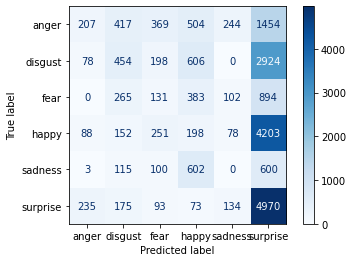

In [16]:
# WEIGHT_NAME = '1_crop_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the image cropping model with Dataset2

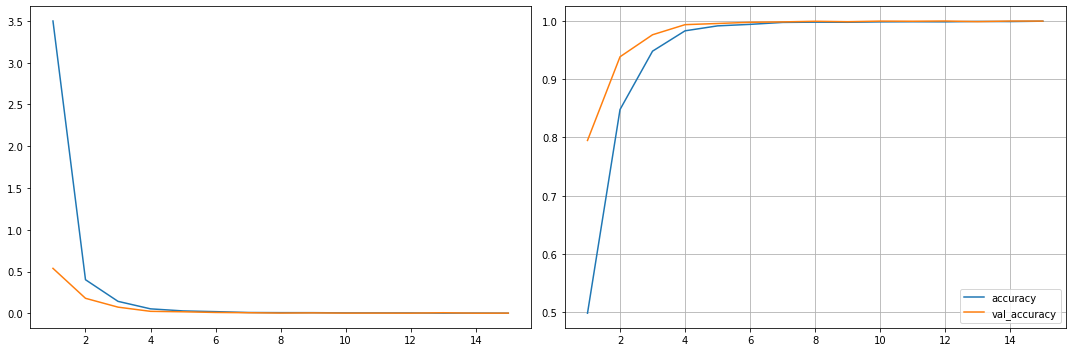

141/141 [==============================] - 16s 109ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9994


In [17]:

path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 97s 2s/step
              precision    recall  f1-score   support

       anger       0.24      0.13      0.17      3195
     disgust       0.17      0.26      0.20      4260
        fear       0.15      0.17      0.16      1775
       happy       0.11      0.03      0.05      4970
     sadness       0.21      0.16      0.18      1775
    surprise       0.26      0.39      0.31      5680

    accuracy                           0.21     21655
   macro avg       0.19      0.19      0.18     21655
weighted avg       0.19      0.21      0.19     21655



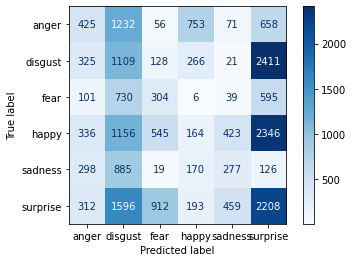

In [18]:
# WEIGHT_NAME = '1_crop_d2.h5'

#Fetch testing data from the dataset2
test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the basic model with Dataset3

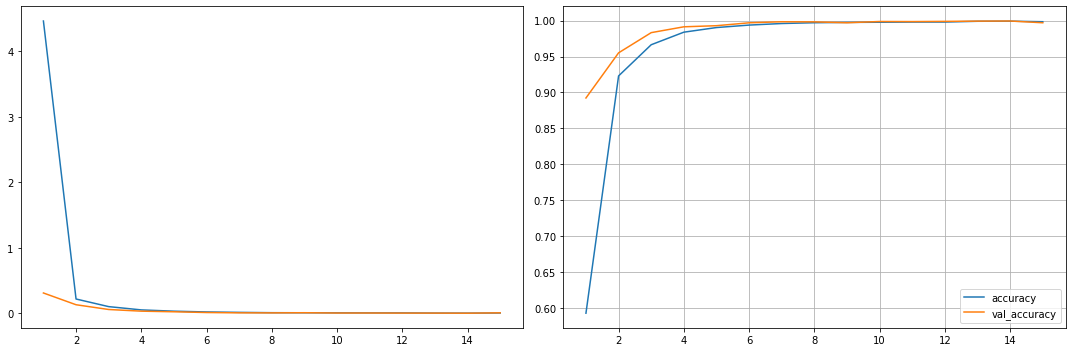

141/141 [==============================] - 17s 115ms/step - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.0077 - val_accuracy: 0.9970


In [19]:

path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_crop_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)

callback_list = [PlotTrain(), early_stopping]
model.fit(train, validation_data=val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 107s 2s/step
              precision    recall  f1-score   support

       anger       0.42      0.06      0.10      3195
     disgust       0.30      0.07      0.12      4260
        fear       0.00      0.00      0.00      1775
       happy       0.23      0.17      0.19      4970
     sadness       0.09      0.08      0.09      1775
    surprise       0.32      0.79      0.45      5680

    accuracy                           0.27     21655
   macro avg       0.23      0.19      0.16     21655
weighted avg       0.26      0.27      0.21     21655



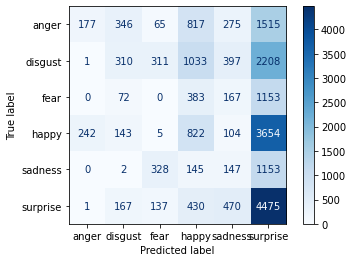

In [20]:
# WEIGHT_NAME = '1_crop_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## ====Intensity Normalization====

Training and Testing on the Intensity Normalization model with Dataset1

In [7]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_IntentNorm_1'
dataset_2_folder_name = 'CKD_IntentNorm_2'
dataset_3_folder_name = 'CKD_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

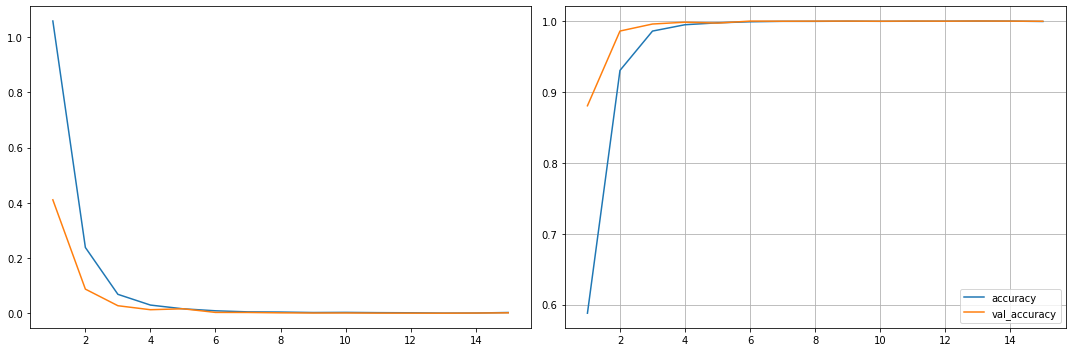

142/142 [==============================] - 18s 122ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0018 - val_accuracy: 0.9997


In [22]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d1.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 106s 2s/step
              precision    recall  f1-score   support

       anger       0.12      0.10      0.11      3195
     disgust       0.35      0.21      0.26      4260
        fear       0.00      0.00      0.00      1775
       happy       0.79      0.65      0.71      4970
     sadness       0.20      1.00      0.33      1420
    surprise       0.93      0.63      0.75      5680

    accuracy                           0.44     21300
   macro avg       0.40      0.43      0.36     21300
weighted avg       0.53      0.44      0.46     21300



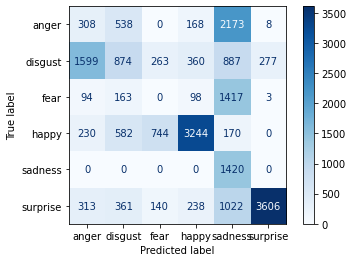

In [23]:
# WEIGHT_NAME = '1_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Intensity Normalization model with Dataset2

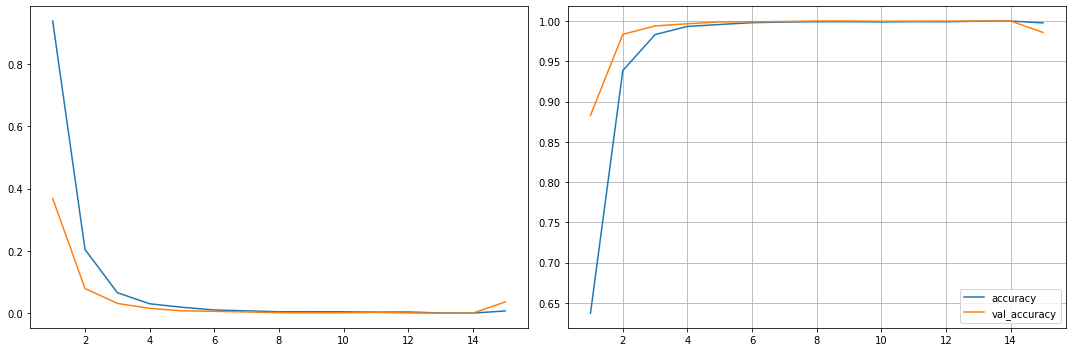

141/141 [==============================] - 17s 114ms/step - loss: 0.0077 - accuracy: 0.9976 - val_loss: 0.0366 - val_accuracy: 0.9858


In [24]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d2.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 97s 2s/step
              precision    recall  f1-score   support

       anger       0.21      0.86      0.34      3195
     disgust       0.68      0.16      0.26      4260
        fear       0.27      0.08      0.12      1775
       happy       0.69      0.23      0.34      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.61      0.58      0.59      5680

    accuracy                           0.37     21655
   macro avg       0.41      0.32      0.28     21655
weighted avg       0.50      0.37      0.34     21655



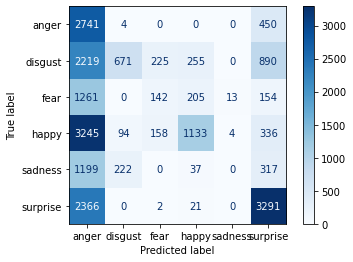

In [25]:
# WEIGHT_NAME = '1_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

We are here

Training and Testing on the Intensity Normalization model with Dataset3

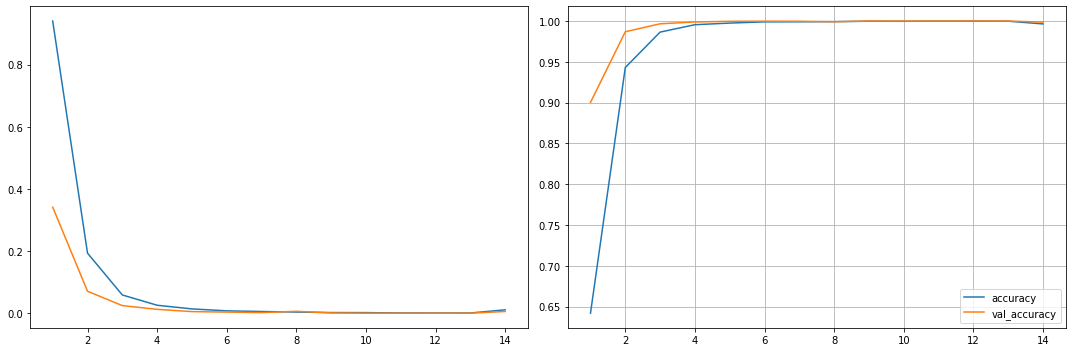

141/141 [==============================] - 15s 105ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0063 - val_accuracy: 0.9986


In [9]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 97s 2s/step
              precision    recall  f1-score   support

       anger       0.62      0.08      0.14      3195
     disgust       0.32      0.60      0.42      4260
        fear       0.00      0.00      0.00      1775
       happy       0.68      0.76      0.72      4970
     sadness       0.64      0.16      0.25      1775
    surprise       0.64      0.79      0.71      5680

    accuracy                           0.52     21655
   macro avg       0.48      0.40      0.37     21655
weighted avg       0.53      0.52      0.47     21655



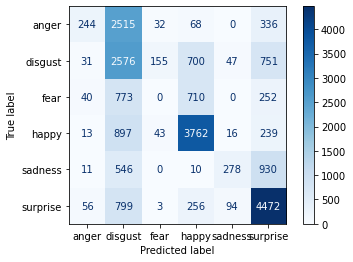

In [10]:
# WEIGHT_NAME = '1_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## ====Image Cropping and Intensity Normalization====

Training and Testing on the Cropping and Intensity Normalization model with Dataset1

In [11]:
project_folder_name = '../COMP_473_Project'
dataset_1_folder_name = 'CKD_Crop_IntentNorm_1'
dataset_2_folder_name = 'CKD_Crop_IntentNorm_2'
dataset_3_folder_name = 'CKD_Crop_IntentNorm_3'

folder_type = ['train', 'Test1', 'Test2', 'Test3', 'val']

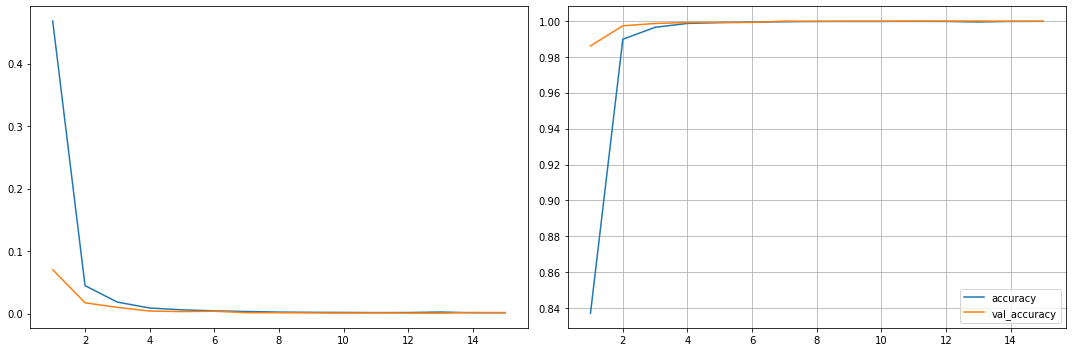

142/142 [==============================] - 10s 68ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0016 - val_accuracy: 0.9997


In [12]:
path_train = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_1_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d1.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()
model.summary()
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21300 images belonging to 6 classes.
43/43 [==============================] - 100s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.11      0.01      0.02      4260
        fear       0.00      0.00      0.00      1775
       happy       0.32      0.12      0.17      4970
     sadness       0.01      0.00      0.00      1420
    surprise       0.26      0.78      0.39      5680

    accuracy                           0.24     21300
   macro avg       0.12      0.15      0.10     21300
weighted avg       0.17      0.24      0.15     21300



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


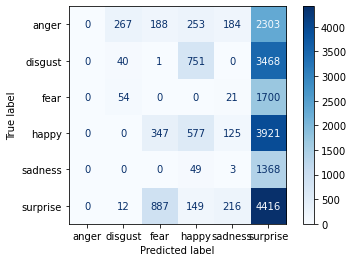

In [13]:
# WEIGHT_NAME = '1_CR_IN_d1.h5'

test_dir = os.path.join(project_folder_name, folder_type[1])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset2

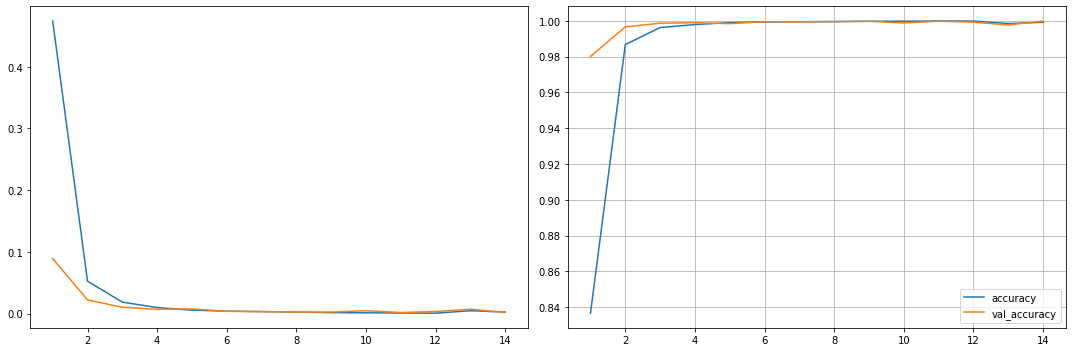

141/141 [==============================] - 10s 68ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0019 - val_accuracy: 0.9998


In [14]:
path_train = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_2_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = '1_CR_IN_d2.h5'

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 92s 2s/step
              precision    recall  f1-score   support

       anger       0.17      0.08      0.11      3195
     disgust       0.26      0.45      0.33      4260
        fear       0.06      0.22      0.09      1775
       happy       0.27      0.08      0.12      4970
     sadness       0.31      0.18      0.23      1775
    surprise       0.25      0.16      0.20      5680

    accuracy                           0.19     21655
   macro avg       0.22      0.19      0.18     21655
weighted avg       0.24      0.19      0.19     21655



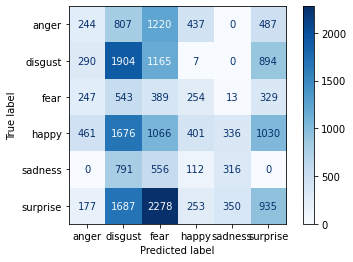

In [15]:
# WEIGHT_NAME = '1_CR_IN_d2.h5'

test_dir = os.path.join(project_folder_name, folder_type[2])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
# predict the category with the input images from the test set
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Training and Testing on the Cropping and Intensity Normalization model with Dataset3


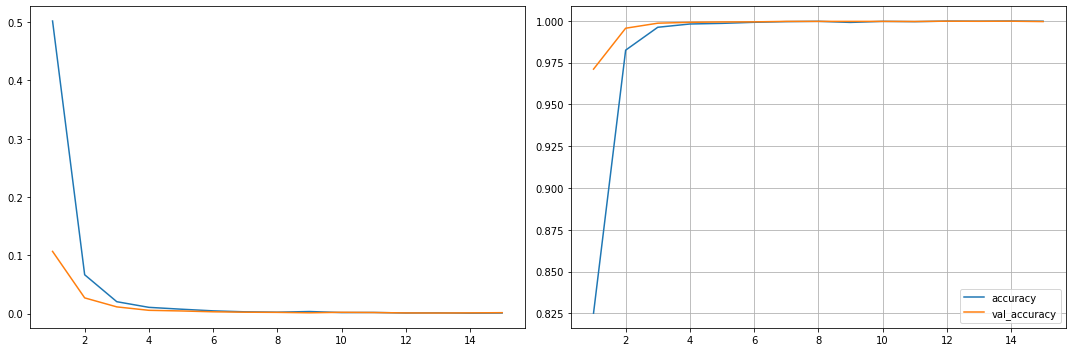

141/141 [==============================] - 10s 68ms/step - loss: 8.3389e-04 - accuracy: 0.9998 - val_loss: 0.0014 - val_accuracy: 0.9996


In [16]:
path_train = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[0])
path_val = os.path.join(project_folder_name, dataset_3_folder_name, folder_type[4])

NUMBER_OF_EPOCHS = 15
IMAGE_WIDTH = 28
IMAGE_HEIGHT = 28
NUMBER_OF_CHANNELS = 1
BATCH_SIZE = 500
OPTIMIZER = 'adam'
LOSS = "sparse_categorical_crossentropy"
MODEL_NAME = "1_CR_IN_d3.h5"

color_mode = ''
if NUMBER_OF_CHANNELS == 3:
    color_mode = 'rgb'
else:
    color_mode = 'grayscale'

train = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)
val = tf.keras.utils.image_dataset_from_directory(
    path_val,
    image_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    color_mode=color_mode
)

data_train = train.map(lambda x, y: (x / 255, y))
data_val = val.map(lambda x, y: (x / 255, y))

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu',
                           input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, NUMBER_OF_CHANNELS)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (7, 7), padding='valid', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])
model.build()

model.summary()

model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                  mode="auto", patience=3,
                                                  restore_best_weights=True)
# compile and fit the model
callback_list = [PlotTrain(), early_stopping]
model.fit(data_train, validation_data=data_val, epochs=NUMBER_OF_EPOCHS, callbacks=callback_list)

model.save(MODEL_NAME)

Found 21655 images belonging to 6 classes.
44/44 [==============================] - 97s 2s/step
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00      3195
     disgust       0.05      0.03      0.04      4260
        fear       0.00      0.00      0.00      1775
       happy       0.17      0.11      0.14      4970
     sadness       0.00      0.00      0.00      1775
    surprise       0.30      0.65      0.41      5680

    accuracy                           0.20     21655
   macro avg       0.09      0.13      0.10     21655
weighted avg       0.13      0.20      0.15     21655



/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ryan/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


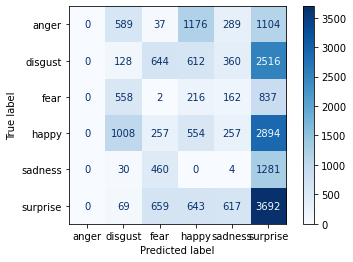

In [17]:
# WEIGHT_NAME = '1_CR_IN_d3.h5'

test_dir = os.path.join(project_folder_name, folder_type[3])
test_generator = tf.keras.preprocessing.image.ImageDataGenerator()
test_ds = test_generator.flow_from_directory(test_dir, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH), batch_size=500,
                                             class_mode='categorical', color_mode="grayscale", shuffle=False)

model.load_weights(MODEL_NAME)

y_true = test_ds.classes
true_class = myClassType(y_true)
y_predict = model.predict(test_ds)
classes_x = np.argmax(y_predict, axis=1)
predicted_class = myClassType(classes_x)

print(classification_report(true_class, predicted_class))
cf_model = confusion_matrix(true_class, predicted_class, labels=classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_model, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()